In [1]:
# File system manangement
import os
import math
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import imblearn

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.svm import SVC

#import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

import lightgbm as lgb

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import make_scorer, roc_auc_score, auc, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

import shap

import warnings
warnings.filterwarnings('ignore')
from pprint import pprint

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
shap.initjs()

In [3]:
#df_app_train = pd.read_csv('df_engineered/df_app_train.csv')
#df_app_test = pd.read_csv('df_engineered/df_app_test.csv')

df_app_train = pd.read_csv('df_engineered_selected/df_app_train_small.csv')
df_app_test = pd.read_csv('df_engineered_selected/df_app_test_small.csv')

#df_app_train_poly = pd.read_csv('df_engineered/df_app_train_poly.csv')
#df_app_test_poly = pd.read_csv('df_engineered/df_app_test_poly.csv')

#df_app_train_domain = pd.read_csv('df_engineered/df_app_train_domain.csv')
#df_app_test_domain = pd.read_csv('df_engineered/df_app_test_domain.csv')

#df_app_train_poly_domain = pd.read_csv('df_engineered/df_app_train_poly_domain.csv')
#df_app_test_poly_domain = pd.read_csv('df_engineered/df_app_test_poly_domain.csv')

In [4]:
df_app_train.shape

(307511, 349)

# Modeling

Nous allons maintenant créer une scoring métier lié à notre problématique de pénalisation des faux négatifs (voir `false_negative_penalty_factor`) qui servira à selectionner et optimiser nos modèles.  
À la suite de ça, nous allons implémenter un grid_search sur plusieurs modèles afin de comparer les scores (auc) et séléctionner le modèle le plus pertinent à optimiser pour répondre à la problématique métier.  
Puis, nous optimiserons le modèle sélectionné avec un random_search puis un nouveau grid_search, afin d'obtenir un modèle performant.  
Enfin, grace à ce modèle optimisé, nous ferons une 'fausse' prédiction (à titre d'example pour le client) mais qui nous servira à expliquer l'importance des features à une echelle globale au modèle, mais aussi individuellement par client.

In [5]:
K_FOLDS_model_selection = 3
K_FOLDS_tuning = 5

sample_size = 1
#sample_size = 0.05

do_SMOTE_optimal_k_search = True

false_negative_penalty_factor = 10
false_positive_penalty_factor = 1

train_test_split_test_size = 0.2

early_stopping_iter = 50

Ici nous déclarons nos fonctions de scoring qui seront utilisé tout au long du modeling grace au make_scorer de scikit learn. Beaucoup sont ici pour que je puisse faire des test et comprendre, mais celle qui nous interessera particulièrement est `business_score` qui permettera de faire un scoring métier et de prendre en compte un cout plus important pour les faux négatifs (mauvais payeurs qui passent pour de bons payeurs)

In [6]:
def weighted_balanced_accuracy(test, pred) :
    tn, fp, fn, tp = confusion_matrix(test, pred).ravel()
    w_TPR = tp / (tp + (10 * fn))
    w_TNR = tn / (tn + fp)
    wb_acc = (w_TPR + w_TNR) / 2
    return wb_acc

def local_balanced_accuracy(test, pred) :
    tn, fp, fn, tp = confusion_matrix(test, pred).ravel()
    w_TPR = tp / (tp + (fn))
    w_TNR = tn / (tn + fp)
    b_acc = (w_TPR + w_TNR) / 2
    return b_acc

def local_accuracy(test, pred) :
    tn, fp, fn, tp = confusion_matrix(test, pred).ravel()
    return (tp + tn) / (tn + fp + fn + tp)

def w_recall(test, pred) :
    tn, fp, fn, tp = confusion_matrix(test, pred).ravel()
    return (tp) / (tp + (10 * fn))

def business_score_func(test, pred) :
    tn, fp, fn, tp = confusion_matrix(test, pred).ravel()
    return  false_negative_penalty_factor * fn + false_positive_penalty_factor * fp

def business_score_func_2(test, pred) :
    tn, fp, fn, tp = confusion_matrix(test, pred).ravel()
    return  ((((10 * fn + 1 * fp) / (tn + fp + fn + tp)) - 0.5) * 2)

def business_score_func_3(test, pred) :
    tn, fp, fn, tp = confusion_matrix(test, pred).ravel()
    return  ((((10 * fn + 1 * fp) / ((tn + fp + fn + tp) * 10))))

# ---------------------------------------------------------------------------------
# This is the function being used for scoring 

def business_score(test, pred_proba, **kwargs) :
    results = {'score' : [], 'threshold' : []}
    
    for threshold in np.linspace(0, 1, 101) :
        pred = (pred_proba >= threshold).astype('int')
        
        score = business_score_func(test, pred) # tested multiple, simple is better
        
        results['score'].append(score)
        results['threshold'].append(threshold)
    
    id_min = np.array(results['score']).argmin()
    
    score = results['score'][id_min]
    
    if 'out_threshold' in kwargs:
        out_threshold = results['threshold'][id_min]
        return out_threshold
    
    return score
# ---------------------------------------------------------------------------------

scoring = {
    'auc': 'roc_auc',
    'auc2': make_scorer(roc_auc_score, response_method=['predict_proba']),
    'accuracy': make_scorer(accuracy_score),
    'b-accuracy': make_scorer(balanced_accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
    'business_score': make_scorer(business_score, greater_is_better=False, response_method='predict_proba'),
    'threshold_score': make_scorer(business_score, response_method='predict_proba', out_threshold=True),
    'weighted_balanced_accuracy': make_scorer(weighted_balanced_accuracy, greater_is_better=True),
    'local_b_accuracy': make_scorer(local_balanced_accuracy, greater_is_better=True),
    'local_accuracy': make_scorer(local_accuracy, greater_is_better=True),
    'w_recall': make_scorer(w_recall, greater_is_better=True),
}

> Note : Dans le `make_scorer` nous avons rajouté le `threshold_score` permettant de récuperer le threshold optimal lors des prochaines cross_validation où ce `make_scorer` sera utilisé.

In [7]:
if (sample_size != 1) :
    working_df = df_app_train.sample(int(df_app_train.shape[0] * sample_size))
else :
    working_df = df_app_train.copy()

train_labels = working_df['TARGET']
y = train_labels

if 'TARGET' in working_df:
    X = working_df.drop(columns = ['TARGET'])
else:
    X = working_df.copy()

imputer = SimpleImputer(strategy = 'median')
scaler = MinMaxScaler(feature_range = (0, 1))

features = list(X.columns)

X = imputer.fit_transform(X)
X = scaler.fit_transform(X)

random_state = 707
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_test_split_test_size, random_state=random_state )

> Nous utilisons ici un simple imputer pour gagner du temps, en temps normal nous pourrions utiliser un Knn avec recherche de nombre de voisins optimal.  

## Selection du nombre de voisins optimal pour SMOTE

Ici je fais une première passe simplement pour selectionner le nombre de voisin optimal pour l'équilibrage des classes. C'est optimisé sur l'auc, et pour un modèle lgbm avec des paramètres par défauts, donc il est tout à fait possible de faire mieux. Dans un monde idéal il serait meme possible de faire passer ce test dans un grid_search ou random_search mais par souci de temps, c'est la solution la plus pragmatique que j'ai pu trouver.

In [8]:
results = {'k' : [], 'score_valid' : []}

fit_params =    {
                    'callbacks' : [lgb.early_stopping(stopping_rounds=early_stopping_iter)],
                    'eval_set' : [(X_test, y_test)], 
                    'eval_metric' : 'auc',
                }

if do_SMOTE_optimal_k_search :
    for k in np.arange(3, 10):
    
        #model = DecisionTreeClassifier(random_state=707)
        model = lgb.LGBMClassifier(n_estimators = 10000, random_state=random_state, verbose = -1)
        over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
        under = RandomUnderSampler(sampling_strategy=0.5)
        steps = [('over', over), ('under', under)]
        pipeline = imbPipeline(steps=steps)
        
        local_X, local_y = pipeline.fit_resample(X_train, y_train)
        
        cv = StratifiedKFold(n_splits=K_FOLDS_tuning, shuffle=True, random_state=random_state)
        scores = cross_validate(model, local_X, local_y, cv=cv, fit_params=fit_params, scoring=scoring, return_estimator=True)
        
        results['k'].append(k)
        results['score_valid'].append(scores['test_auc'].mean())


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[206]	valid_0's auc: 0.781225	valid_0's binary_logloss: 0.366605
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[137]	valid_0's auc: 0.778022	valid_0's binary_logloss: 0.368609
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[154]	valid_0's auc: 0.779464	valid_0's binary_logloss: 0.368888
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[148]	valid_0's auc: 0.778279	valid_0's binary_logloss: 0.368768
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's auc: 0.776344	valid_0's binary_logloss: 0.370144
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[149]	valid_0's auc: 0.778455	valid_0's binary_logloss: 0.368176
Training until validation scores d

In [9]:
if do_SMOTE_optimal_k_search :
    results = pd.DataFrame(results)
    results = results.sort_values(by='score_valid', ascending = False)
    results.reset_index(inplace=True)
    print(results)

   index  k  score_valid
0      0  3     0.802924
1      1  4     0.801853
2      2  5     0.801745
3      5  8     0.801672
4      3  6     0.801435
5      6  9     0.800780
6      4  7     0.799993


In [10]:
if do_SMOTE_optimal_k_search :
    optimal_k = results['k'][results['score_valid'].argmax()]
    print(f"The optimal number of neighbors for over sampling SMOTE is {optimal_k}.")
else :
    optimal_k = 3

The optimal number of neighbors for over sampling SMOTE is 3.


## Model Selection

Nous allons tester plusieurs type de modèles différents avec quelques hyperparamètres simple pour commencer, ce qui nous donnera dès le départ une bonne idée du modèle adéquat à utiliser.  
`classifiers` est un dictionnaire qui contient le modèles + un dict des hyperparamètres pour le grid_search + des paramètres optionnel pour le fit (requis pour lgbm)

In [11]:
param_SMOTE = {
    'over__sampling_strategy' : [0.3],
    'under__sampling_strategy' : ['auto']
}

classifiers = {
    "LGB" : [lgb.LGBMClassifier(random_state = random_state, n_estimators=10000),
            {
                'model__num_leaves': [20, 33, 50],
                'model__learning_rate': [0.05, 0.1, 0.2],
                'model__min_child_samples': [20, 40, 60],
            },
            {  
                'model__callbacks' : [lgb.early_stopping(stopping_rounds=early_stopping_iter)],
                'model__eval_set' : [(X_test, y_test)], 
                'model__eval_metric' : 'auc'
            }],
    "log_reg" : [LogisticRegression(random_state=random_state),
            {
                'model__solver' : ['newton-cg', 'lbfgs', 'liblinear'],
                'model__penalty' : ['None', 'l1', 'l2'],
                'model__C' : [100, 1.0, 0.01]
            }],
    #"KNN" : [KNeighborsClassifier(),
    #        {
    #            'model__n_neighbors' : [3, 7],
    #            'model__metric' : ['euclidean', 'manhattan'],
    #            'model__weights' : ['uniform', 'distance']
    #        }],
    "random_forest" : [RandomForestClassifier(random_state = random_state, verbose = 0, n_jobs = -1),
            {
                'model__max_features' : ['sqrt', 'log2'],
                'model__max_depth' : [3, 6, 9],
                'model__max_leaf_nodes': [3, 6, 9]
            }]
    #"SVC" : [SVC(random_state=random_state)], #takes too long
}

Fonction qui servira a parcourir notre dictionnaire de modèle, et d'enregistrer les résultats pour futur plot

In [12]:
def do_predict(X_train, y_train, X_test, y_test, results, name, model, grid_params=None, fit_params=None) :
    grip_prms = None

    # GridSearch
    over = SMOTE(k_neighbors=optimal_k)
    under = RandomUnderSampler()
    
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = imbPipeline(steps=steps)

    cv = StratifiedKFold(n_splits=K_FOLDS_model_selection, shuffle=True, random_state=random_state)

    if grid_params != None :
        grip_prms = grid_params | param_SMOTE
    else :
        grip_prms = param_SMOTE

    grid_search = GridSearchCV(pipeline, param_grid = grip_prms, scoring=scoring, refit='business_score',
                            cv = cv, n_jobs = -1, verbose = 2)

    # Test score with SMOTE
    if (fit_params != None) :
        grid_search.fit(X_train, y_train, **fit_params)
    else :
        grid_search.fit(X_train, y_train)

    best_index = grid_search.best_index_
    cv_results = grid_search.cv_results_

    pred_proba = grid_search.predict_proba(X_test)[:,1]
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, pred_proba)
    roc_auc = auc(false_positive_rate, true_positive_rate).round(4)

    predict_time = cv_results['mean_score_time'][best_index]
    train_time = cv_results['mean_fit_time'][best_index]

    test_auc = roc_auc_score(y_test, pred_proba)
    test_biz_score = business_score(y_test, pred_proba)

    # append results
    row = []
    row.append(name)
    row.append(test_auc)
    row.append(abs(test_biz_score))
    row.append(abs(cv_results['mean_test_business_score'][best_index]))
    row.append(cv_results['mean_test_threshold_score'][best_index])
    row.append(cv_results['std_test_threshold_score'][best_index])
    row.append(cv_results['mean_test_auc'][best_index])
    row.append(cv_results['std_test_auc'][best_index])
    row.append(cv_results['mean_test_accuracy'][best_index])
    row.append(cv_results['mean_test_precision'][best_index])
    row.append(cv_results['mean_test_f1_score'][best_index])
    row.append(cv_results['mean_test_recall'][best_index])
    row.append(false_positive_rate)
    row.append(true_positive_rate)
    row.append(train_time)
    row.append(predict_time)
    row.append(grid_search.best_params_)
    results.loc[len(results)] = row

In [13]:
results = pd.DataFrame(columns=['name', 'auc_test', 'biz_score_test', 'biz_score_valid', 'biz_threshold_mean', 'biz_threshold_std', 'auc_valid', 'auc_std', 'accuracy_score', 'precision_score', 'f1_score', 'recall_score', 'fpr', 'tpr', 'train_time_mean', 'predict_time_mean', 'best_parameters'])

for key, value in classifiers.items() :
    do_predict(X_train, y_train, X_test, y_test, results, key, *value)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[LightGBM] [Info] Number of positive: 67858, number of negative: 67858
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88141
[LightGBM] [Info] Number of data points in the train set: 135716, number of used features: 348
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[661]	valid_0's auc: 0.782155	valid_0's binary_logloss: 0.3069
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [14]:
results.sort_values(by='biz_score_valid', inplace=True, ascending=True)
results

,name,auc_test,biz_score_test,biz_score_valid,biz_threshold_mean,biz_threshold_std,auc_valid,auc_std,accuracy_score,precision_score,f1_score,recall_score,fpr,tpr,train_time_mean,predict_time_mean,best_parameters
0,LGB,0.782155,30730,41408.333333,0.253333,0.012472,0.774376,0.003084,0.891768,0.315478,0.304322,0.293933,"[0.0, 0.0, 0.0, 1.7701621468526518e-05, 1.7701...","[0.0, 0.00019956096587507485, 0.00199560965875...",150.952200,4.782207,"{'model__learning_rate': 0.05, 'model__min_chi..."
1,log_reg,0.763813,32291,43164.000000,0.500000,0.014142,0.757858,0.003474,0.705526,0.168844,0.270291,0.677147,"[0.0, 1.7701621468526518e-05, 5.31048644055795...","[0.0, 0.0, 0.0, 0.0003991219317501497, 0.00039...",77.002017,5.321100,"{'model__C': 100, 'model__penalty': 'l2', 'mod..."
2,random_forest,0.674082,39161,52706.333333,0.476667,0.004714,0.665963,0.005683,0.753833,0.151128,0.225652,0.445241,"[0.0, 1.7701621468526518e-05, 5.31048644055795...","[0.0, 0.0, 0.0, 0.0003991219317501497, 0.00039...",39.223452,14.208239,"{'model__max_depth': 6, 'model__max_features':..."


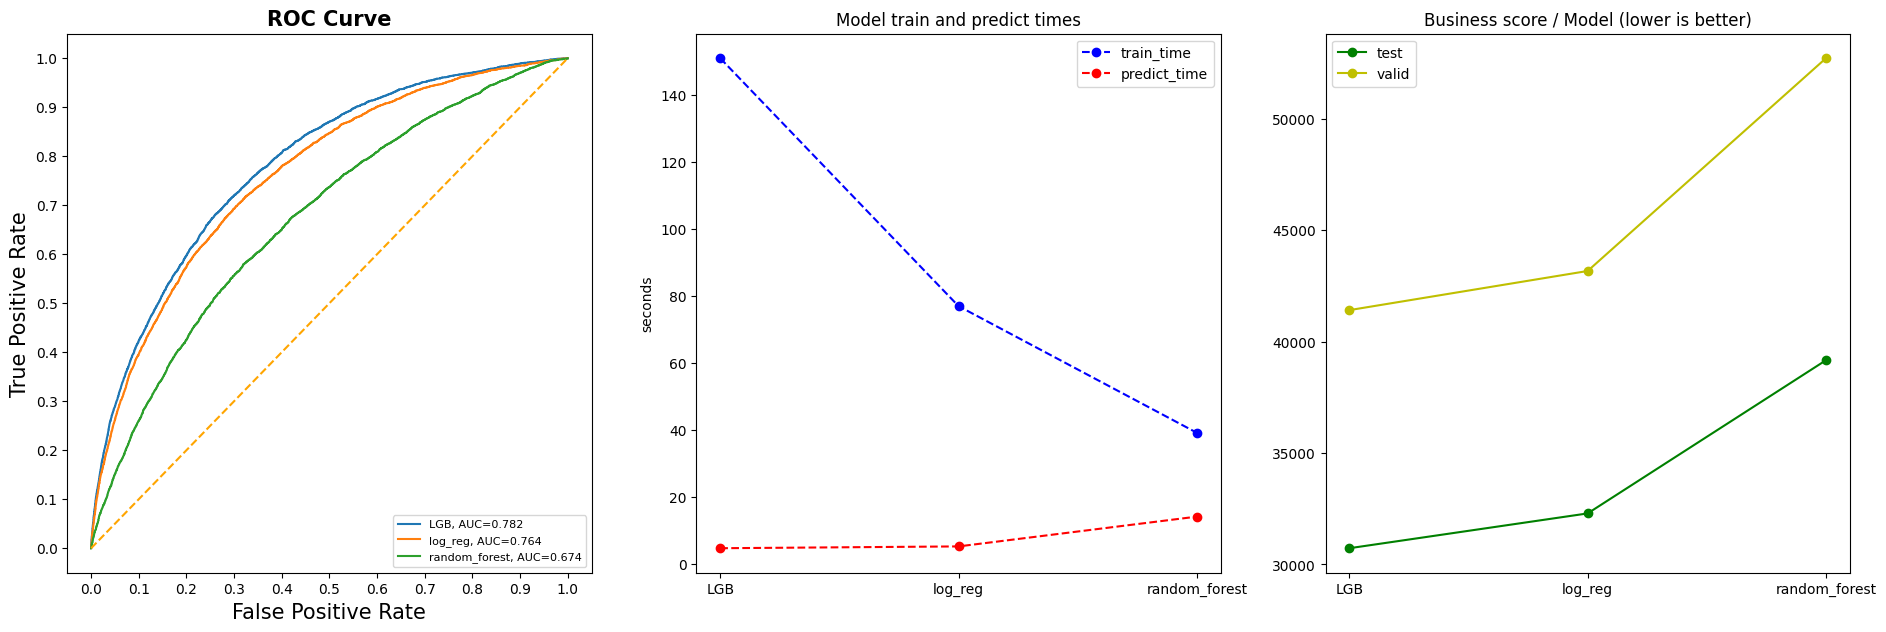

In [15]:
plt.subplots(1, 3, figsize=(23, 7))

plt.subplot(131)
for i in results.index:
    plt.plot(results.loc[i]['fpr'], 
            results.loc[i]['tpr'], 
            label="{}, AUC={:.3f}".format(results.loc[i]['name'], results.loc[i]['auc_test']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve', fontweight='bold', fontsize=15)
plt.legend(prop={'size':8}, loc='lower right')

plt.subplot(132)

plt.plot(results['name'], results['train_time_mean'], 'bo--', label = 'train_time')
plt.plot(results['name'], results['predict_time_mean'], 'ro--', label = 'predict_time')
#plt.ylim(ymin = -10, ymax = 0)
plt.legend()
#plt.xlabel(name)
plt.ylabel('seconds')
plt.title('Model train and predict times')

plt.subplot(133)
plt.plot(results['name'], results['biz_score_test'], 'go-', label = 'test')
plt.plot(results['name'], results['biz_score_valid'], 'yo-', label = 'valid')
plt.legend()
plt.title('Business score / Model (lower is better)')

plt.show()

Ici c'est le gradient boosting de la librairie LGBM qui est le plus performant, c'est donc ce modèle que nous allons utiliser par la suite.

# Model Tuning

On s'assure d'avoir un environnement de travail propre.

In [16]:
if (sample_size != 1) :
    working_df = df_app_train.sample(int(df_app_train.shape[0] * sample_size))
else :
    working_df = df_app_train.copy()

train_labels = working_df['TARGET']
y = train_labels

if 'TARGET' in working_df:
    X = working_df.drop(columns = ['TARGET'])
else:
    X = working_df.copy()

imputer = SimpleImputer(strategy = 'median')
scaler = MinMaxScaler(feature_range = (0, 1))

features = list(X.columns)

X = imputer.fit_transform(X) # impute needed for smote
#X = scaler.fit_transform(X) # not sure need to scale with xgb model
#X = X.values

random_state = 707
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_test_split_test_size, random_state=random_state )

## Baseline

Plutot que d'avoir une baseline avec un DummyClassifier, j'ai pris le parti de faire un scoring avec le `LGBMClassifier` avec des paramètres par défaut. Je lui mets un hyperparamètres `n_estimators` à 10k car je vais lui appliquer la méthose de l'early_stopping, et c'est lui qui nous dira de combien d'arbres il a besoin pour fonctionner de façon optimale. Nous utiliserons cette technique tout au long du notebook.

### Scikit learn cv + lgbm model

In [17]:
model = lgb.LGBMClassifier(random_state=random_state, n_estimators = 10000)

fit_params =    {
                    'callbacks' : [lgb.early_stopping(stopping_rounds=early_stopping_iter)],
                    'eval_set' : [(X_test, y_test)],
                    'eval_metric' : 'auc'
                }

cv = StratifiedKFold(n_splits=K_FOLDS_tuning, shuffle=True, random_state=random_state)

scores = cross_validate(model, X_train, y_train, cv=cv, fit_params=fit_params, scoring=scoring, return_estimator=True)

[LightGBM] [Info] Number of positive: 15851, number of negative: 180955
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.258279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61862
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 348
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080541 -> initscore=-2.435016
[LightGBM] [Info] Start training from score -2.435016
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[133]	valid_0's auc: 0.780762	valid_0's binary_logloss: 0.240941
[LightGBM] [Info] Number of positive: 15851, number of negative: 180955
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.251804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61816
[LightGBM] [Info] Number of data points in the train set: 196806, number

On cherche ici le n_estimator optimal après early stopping, on prends la moyenne de chaque estimator utilisé pendant la cross validation

In [18]:
n_estimator_list=[]
for i in range(0, K_FOLDS_tuning) :
    n_estimator_list.append(scores['estimator'][i].n_estimators_)

estimator_array = np.array(n_estimator_list).mean()
estimator_array = estimator_array
optimal_n_estimator = estimator_array.mean().astype(int)

In [19]:
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(scores['test_auc'].mean(), scores['test_auc'].std()))
print('The optimal number of boosting rounds (estimators) was {}.'.format(optimal_n_estimator))

The maximum validation ROC AUC was: 0.77646 with a standard deviation of 0.00563.
The optimal number of boosting rounds (estimators) was 129.


In [20]:
scores['test_threshold_score'].mean()

0.088

test score

In [21]:
model.n_estimators = optimal_n_estimator

model.fit(X_train, y_train)

preds = model.predict_proba(X_test)[:, 1]

baseline_test_auc = roc_auc_score(y_test, preds)

[LightGBM] [Info] Number of positive: 19814, number of negative: 226194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.303282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61853
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 348
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080542 -> initscore=-2.435004
[LightGBM] [Info] Start training from score -2.435004


In [22]:
print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_test_auc))

The baseline model scores 0.78131 ROC AUC on the test set.


## Random Search : LightGBM

In [23]:
model = lgb.LGBMClassifier(random_state=random_state, n_estimators = 10000)

print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 10000,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': 707,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}


- `min_child_samples` et `min_child_weight` limitent tout les deux la complexité des arbres de décisions en ajustant le minimum de feuilles requis, nous n'utiliserons qu'un des deux.
- `n_estimators` sera déterminé par l'early stopping

Nous allons aussi rajouter des hyperparamètres pour l'over et l'undersampling afin de voir quelles seraient les meilleurs options pour notre model final.

In [24]:
fit_params = {
    'model__callbacks' : [lgb.early_stopping(stopping_rounds=early_stopping_iter)],
    'model__eval_set' : [(X_test, y_test)], 
    'model__eval_metric' : 'auc', # voir si possible d'y mettre le score business, aurtement l'early stop sera optimisé pour l'auc (ce qui n'est pas très grave)
}

param_SMOTE = {
    'over__sampling_strategy' : [0.3, 0.5],
    'under__sampling_strategy' : [0.5, 'auto']
}

param_grid = {
    'model__boosting_type': ['gbdt'],
    'model__is_unbalance': [False],
    'model__num_leaves': list(range(20, 50)),
    'model__learning_rate': list(np.linspace(0.05, 0.3, 15)),
    'model__subsample_for_bin': list(range(170000, 250000, 20000)),
    'model__min_child_samples': list(range(20, 50, 5)),
    'model__reg_alpha': list(np.linspace(0, 1, 10)),
    'model__reg_lambda': list(np.linspace(0, 1, 10)),
    'model__colsample_bytree': list(np.linspace(0.6, 1, 5)),
    'model__subsample': list(np.linspace(0.5, 1, 10)),
}

In [25]:
over = SMOTE(k_neighbors=optimal_k)
under = RandomUnderSampler()
steps = [('over', over), ('under', under), ('model', model)]

pipeline = imbPipeline(steps)
all_params = param_grid | param_SMOTE
cv = StratifiedKFold(n_splits=K_FOLDS_tuning, shuffle=True, random_state=random_state)

rdm_search = RandomizedSearchCV(estimator=pipeline, param_distributions=all_params,
                                n_iter=100, scoring=scoring, refit='business_score',
                                cv=cv, verbose=2, random_state=random_state, n_jobs=-1,
                                return_train_score=True)

rdm_search.fit(X_train, y_train, **fit_params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[LightGBM] [Info] Number of positive: 67858, number of negative: 135716
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.283805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88262
[LightGBM] [Info] Number of data points in the train set: 203574, number of used features: 348
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[180]	valid_0's auc: 0.784092	valid_0's binary_logloss: 0.249834


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=707, shuffle=True),
                   estimator=Pipeline(steps=[('over', SMOTE(k_neighbors=3)),
                                             ('under', RandomUnderSampler()),
                                             ('model',
                                              LGBMClassifier(n_estimators=10000,
                                                             random_state=707))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__boosting_type': ['gbdt'],
                                        'model__colsample_bytree': [0.6, 0.7,
                                                                    0.8, 0.9,
                                                                    1....
                            'precision': make_scorer(precision_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict'),
                            'threshold_score': make_scorer(business_score, response_method='predict_proba', out_threshold=True),
                            'w_recall': make_scorer(w_recall, response_method='predict'),
                            'weighted_balanced_accuracy': make_scorer(weighted_balanced_accuracy, response_method='predict')},
                   verbose=2)

In [26]:
cv_results = rdm_search.cv_results_

optimal_n_estimator = rdm_search.best_estimator_['model'].n_estimators_

print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['mean_test_auc'][rdm_search.best_index_], cv_results['std_test_auc'][rdm_search.best_index_]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(optimal_n_estimator))

The maximum validation ROC AUC was: 0.77844 with a standard deviation of 0.00540.
The optimal number of boosting rounds (estimators) was 180.


Test auc :

In [27]:
model =  rdm_search.best_estimator_
model.fit(X_train, y_train, **fit_params)

y_prob = model.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
test_auc = auc(false_positive_rate, true_positive_rate).round(4)

[LightGBM] [Info] Number of positive: 67858, number of negative: 135716
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 88261
[LightGBM] [Info] Number of data points in the train set: 203574, number of used features: 348
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[238]	valid_0's auc: 0.783753	valid_0's binary_logloss: 0.249415


In [28]:
print('The best random search model scores {:.5f} ROC AUC on the test set.'.format(test_auc))

The best random search model scores 0.78380 ROC AUC on the test set.


In [29]:
def plot_grid_results(grid) :
    df_results = pd.DataFrame(grid.cv_results_)

    plt.figure(figsize = (20, 30))

    i = 0
    for param in grid.best_params_.keys():
        if not param.startswith('model') :
            continue
        full_name = 'param_' + param
        local_result = df_results[[full_name, 'mean_test_business_score', 'mean_fit_time', 'mean_score_time']].sort_values(by=full_name)
        local_result = local_result.groupby(full_name).agg(['mean', 'std']).reset_index()

        plt.subplot(len(grid.best_params_), 2, i + 1)
        plt.grid(axis='y')
        plt.errorbar(local_result[full_name], local_result['mean_test_business_score']['mean'], local_result['mean_test_business_score']['std'], linestyle='--', marker='o', ecolor='orange')
        plt.title(param + " score")

        i=i+1

        plt.subplot(len(grid.best_params_), 2, i + 1)
        plt.grid(axis='y')
        plt.errorbar(local_result[full_name], local_result['mean_fit_time']['mean'], local_result['mean_fit_time']['std'], linestyle='-', marker='s', label='train time')
        plt.errorbar(local_result[full_name], local_result['mean_score_time']['mean'], local_result['mean_score_time']['std'], linestyle='-', marker='s', label='predict time')
        plt.title(param + " times")
        plt.legend()

        i=i+1

    plt.tight_layout(h_pad = 3)
    plt.show()

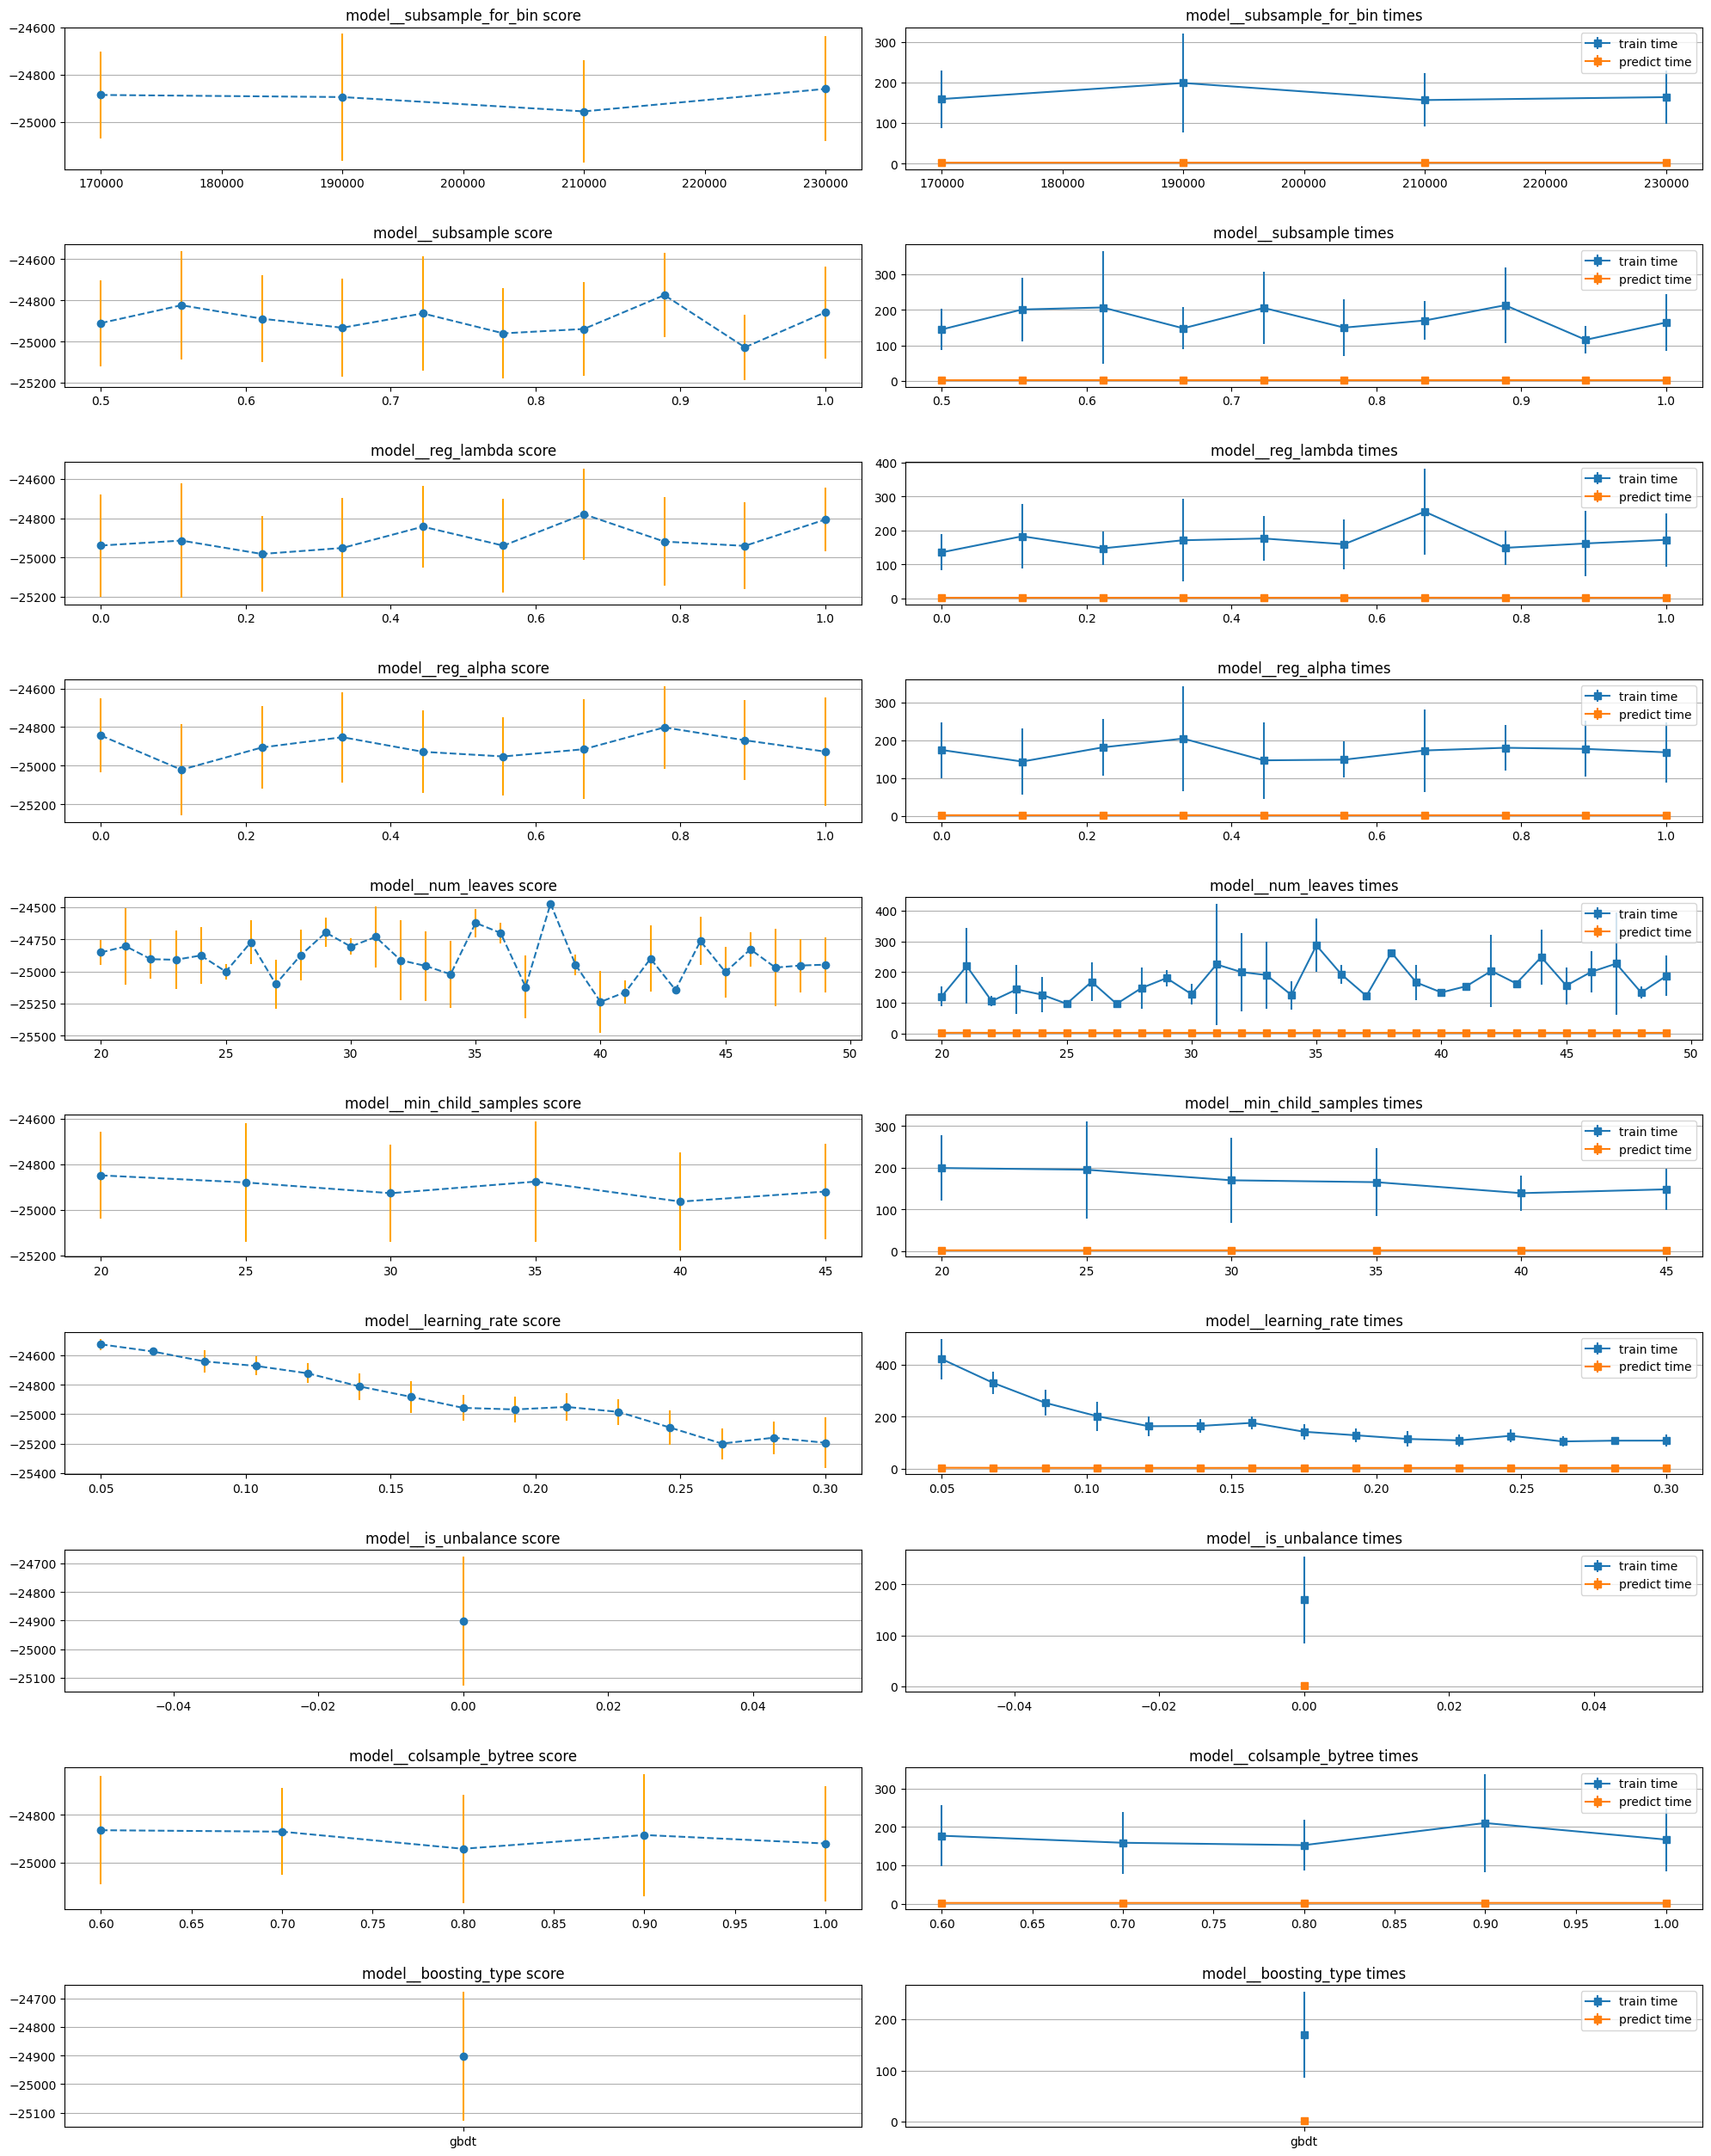

In [30]:
plot_grid_results(rdm_search)

## Grid Search : LightGBM

Nous allons maintenant peaufiner les resultats apporté par la random search précendant grace à un grid search, en partant des hyperparamètres optimaux et étirant nos recherches aux proches voisins.

In [31]:
rdm_search.best_params_

{'under__sampling_strategy': 0.5,
 'over__sampling_strategy': 0.3,
 'model__subsample_for_bin': 230000,
 'model__subsample': 0.5555555555555556,
 'model__reg_lambda': 0.2222222222222222,
 'model__reg_alpha': 0.7777777777777777,
 'model__num_leaves': 38,
 'model__min_child_samples': 25,
 'model__learning_rate': 0.08571428571428572,
 'model__is_unbalance': False,
 'model__colsample_bytree': 0.6,
 'model__boosting_type': 'gbdt'}

In [32]:
fit_params = {
    'model__callbacks' : [lgb.early_stopping(stopping_rounds=early_stopping_iter)],
    'model__eval_set' : [(X_test, y_test)], 
    'model__eval_metric' : 'auc', # voir si possible d'y mettre le score business, autrement l'early stop sera optimisé pour l'auc (ce qui n'est pas très grave)
}

#param_SMOTE = {
#    'over__sampling_strategy' : [0.1, 0.3],
#    'under__sampling_strategy' : [0.5, 'auto']
#}

param_grid = {
    'model__num_leaves': list(range(48, 51, 1)),
    'model__learning_rate': list(np.linspace(0.05, 0.1, 3)),
    'model__subsample_for_bin': list(range(225000, 235000, 5000)),
    'model__min_child_samples': list(range(43, 47, 2)),
    'model__subsample': list(np.linspace(0.82, 0.85, 3)),
}

In [33]:
pipe = rdm_search.best_estimator_ # over and under inside

cv = StratifiedKFold(n_splits=K_FOLDS_tuning, shuffle=True, random_state=random_state)

grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, refit='business_score',
                cv=cv, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train, **fit_params)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Info] Number of positive: 67858, number of negative: 135716
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.318671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88253
[LightGBM] [Info] Number of data points in the train set: 203574, number of used features: 348
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[324]	valid_0's auc: 0.78522	valid_0's binary_logloss: 0.248928


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=707, shuffle=True),
             estimator=Pipeline(steps=[('over',
                                        SMOTE(k_neighbors=3,
                                              sampling_strategy=0.3)),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.5)),
                                       ('model',
                                        LGBMClassifier(colsample_bytree=0.6,
                                                       is_unbalance=False,
                                                       learning_rate=0.08571428571428572,
                                                       min_child_samples=25,
                                                       n_estimators=10000,
                                                       num_leav...
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict'),
                      'threshold_score': make_scorer(business_score, response_method='predict_proba', out_threshold=True),
                      'w_recall': make_scorer(w_recall, response_method='predict'),
                      'weighted_balanced_accuracy': make_scorer(weighted_balanced_accuracy, response_method='predict')},
             verbose=2)

In [34]:
cv_results = grid_search.cv_results_

optimal_n_estimator = grid_search.best_estimator_['model'].n_estimators_

print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['mean_test_auc'][grid_search.best_index_], cv_results['std_test_auc'][grid_search.best_index_]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(optimal_n_estimator))

The maximum validation ROC AUC was: 0.77989 with a standard deviation of 0.00544.
The optimal number of boosting rounds (estimators) was 324.


In [35]:
pprint(grid_search.best_params_)
print(grid_search.best_score_)

{'model__learning_rate': 0.05,
 'model__min_child_samples': 43,
 'model__num_leaves': 49,
 'model__subsample': 0.82,
 'model__subsample_for_bin': 225000}
-24397.0


### Test score

In [36]:
final_model =  grid_search.best_estimator_

y_prob = final_model.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate).round(4)

In [37]:
print('The final model scores {:.5f} ROC AUC on the test set.'.format(roc_auc))

The final model scores 0.78520 ROC AUC on the test set.


In [38]:
final_model_threshold = cv_results['mean_test_threshold_score'][grid_search.best_index_]
final_model_threshold

0.14

In [39]:
final_model_params = final_model['model'].get_params()
oversampling_params = final_model['over'].get_params()
undersampling_params = final_model['under'].get_params()

In [40]:
oversampling_params

{'k_neighbors': 3,
 'n_jobs': None,
 'random_state': None,
 'sampling_strategy': 0.3}

In [41]:
undersampling_params

{'random_state': None, 'replacement': False, 'sampling_strategy': 0.5}

In [42]:
final_model_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.6,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': -1,
 'min_child_samples': 43,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 10000,
 'n_jobs': None,
 'num_leaves': 49,
 'objective': None,
 'random_state': 707,
 'reg_alpha': 0.7777777777777777,
 'reg_lambda': 0.2222222222222222,
 'subsample': 0.82,
 'subsample_for_bin': 225000,
 'subsample_freq': 0,
 'is_unbalance': False}

Nous avons un modèle avec des hyperparamètres optimisé, et entrainé. À titre d'exemple pour le client, voyont les prédictions sur le jeu de test.

# Prédictions test

In [43]:
final_model = grid_search.best_estimator_

### Predict

In [44]:
proba = final_model.predict_proba(X_test)[:,1]
preds = (proba >= final_model_threshold).astype('int')

final_predict_data = {'proba' : proba, 'pred' : preds}
final_predict_data = pd.DataFrame(final_predict_data)
final_predict_data.head(10)

,proba,pred
0,0.066626,0
1,0.182923,1
2,0.039213,0
3,0.392672,1
4,0.026619,0
5,0.055872,0
6,0.114671,0
7,0.127796,0
8,0.111798,0
9,0.029475,0


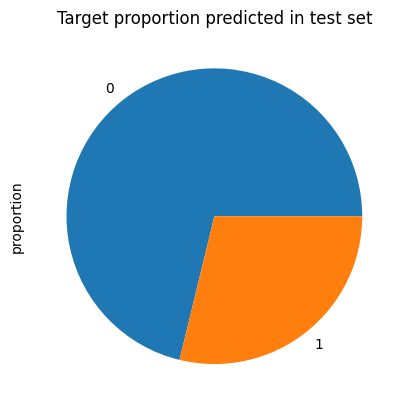

In [45]:
final_predict_data['pred'].value_counts(normalize=True).plot(kind='pie')
plt.title("Target proportion predicted in test set")
plt.show()

#### Distribution

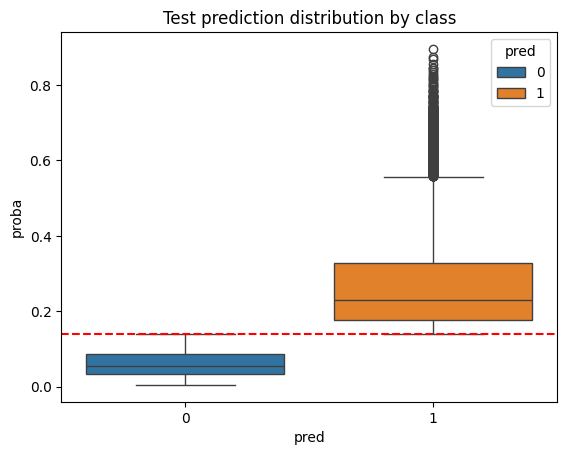

In [46]:
sns.boxplot(data=final_predict_data, x="pred", y="proba", hue='pred')
plt.axhline(y = final_model_threshold, color = 'r', linestyle = '--') 
plt.title("Test prediction distribution by class")
plt.show()

# Explicabilité / SHAP

Nous allons d'abords essayer d'avoir une explication globale des features les + importantes pour le modèles, puis nous essayerons d'expliquer la relation de quelques individus à ces features.

### Naïve

In [47]:
def plot_feature_importances(df, threshold = 0.9):
    plt.rcParams['font.size'] = 18

    df = df.sort_values('importance', ascending = False).reset_index()

    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    plt.figure(figsize = (10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')

    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    plt.xlabel('Normalized Importance')
    plt.title('Feature Importances')
    plt.show()

    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.title('Cumulative Feature Importance')
    plt.show()

    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('_____________________________________________________________________')
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

    return df

In [48]:
train_columns = working_df.drop(columns = ['TARGET']).columns

best_model = grid_search.best_estimator_['model']

fi = final_model['model'].feature_importances_

feature_importances = pd.DataFrame({'feature': list(train_columns), 'importance': fi}).sort_values('importance', ascending = False)
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])

print('\nThere are %d features with 0.0 importance' % len(zero_features))


There are 2 features with 0.0 importance


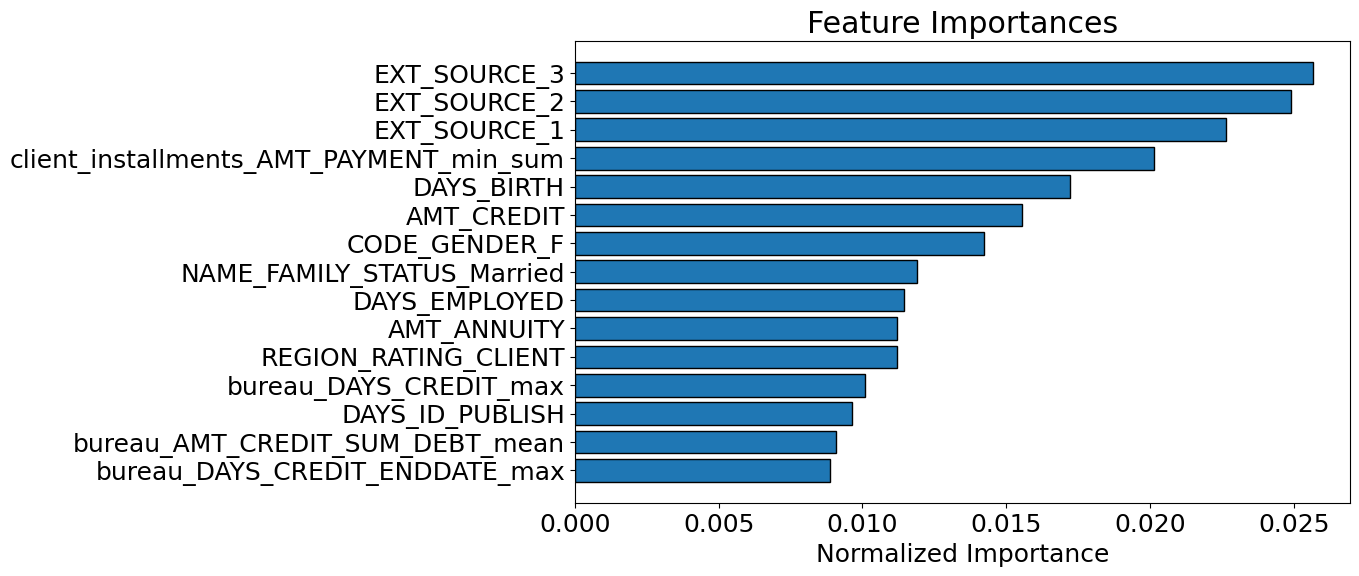

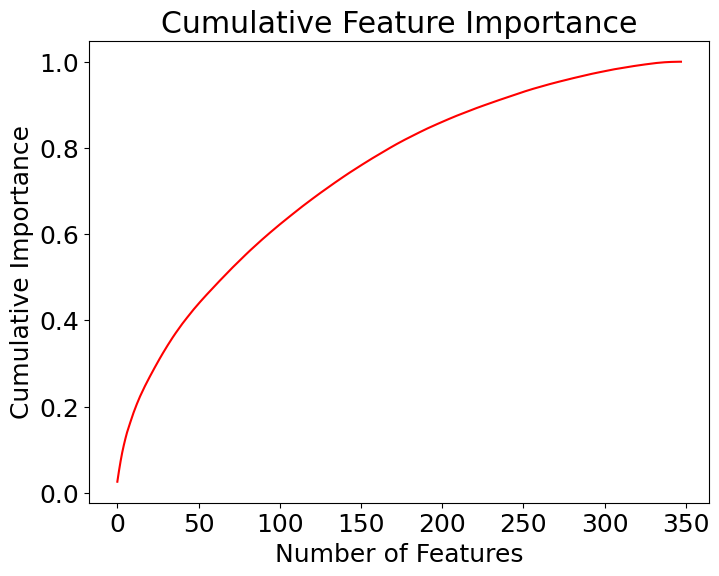

_____________________________________________________________________
270 features required for 0.95 of cumulative importance


,index,feature,importance,importance_normalized,cumulative_importance
0,2,EXT_SOURCE_3,399,0.025656,0.025656
1,1,EXT_SOURCE_2,387,0.024884,0.050540
2,0,EXT_SOURCE_1,352,0.022634,0.073174
3,3,client_installments_AMT_PAYMENT_min_sum,313,0.020126,0.093300
4,4,DAYS_BIRTH,268,0.017233,0.110532
...,...,...,...,...,...
343,346,client_bureau_balance_STATUS_2_count_norm_max,2,0.000129,0.999807
344,336,previous_NAME_SELLER_INDUSTRY_Industry_count_norm,2,0.000129,0.999936
345,317,previous_NAME_CASH_LOAN_PURPOSE_Urgent needs_c...,1,0.000064,1.000000
346,326,ORGANIZATION_TYPE_Bank,0,0.000000,1.000000


In [49]:
plot_feature_importances(feature_importances, threshold = 0.95)

### SHAP

In [50]:
shap_model = final_model['model']

In [51]:
fit_params = {
    'callbacks' : [lgb.early_stopping(stopping_rounds=early_stopping_iter)],
    'eval_set' : [(X_test, y_test)], 
    'eval_metric' : 'auc', # voir si possible d'y mettre le score business, aurtement l'early stop sera optimisé pour l'auc (ce qui n'est pas très grave)
}
shap_model.fit(X_train, y_train, **fit_params)

[LightGBM] [Info] Number of positive: 19814, number of negative: 226194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.291176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61914
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 348
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080542 -> initscore=-2.435004
[LightGBM] [Info] Start training from score -2.435004
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[303]	valid_0's auc: 0.785305	valid_0's binary_logloss: 0.239153


LGBMClassifier(colsample_bytree=0.6, is_unbalance=False, learning_rate=0.05,
               min_child_samples=43, n_estimators=10000, num_leaves=49,
               random_state=707, reg_alpha=0.7777777777777777,
               reg_lambda=0.2222222222222222, subsample=0.82,
               subsample_for_bin=225000)

On note ici les ids des probas les plus haute et basse

In [52]:
best_client_id = final_predict_data['proba'].argmin()
worst_client_id = final_predict_data['proba'].argmax()

In [53]:
explainer_test = shap.TreeExplainer(final_model['model'], X_test, feature_names=features)
#explainer_train = shap.TreeExplainer(final_model['model'], X_train, feature_names=features)
explainer_train = shap.TreeExplainer(final_model['model'])

In [54]:
shap_values = explainer_test(X_test[[best_client_id, worst_client_id]])

Ici nous avons l'exemple d'un "très bon" client.

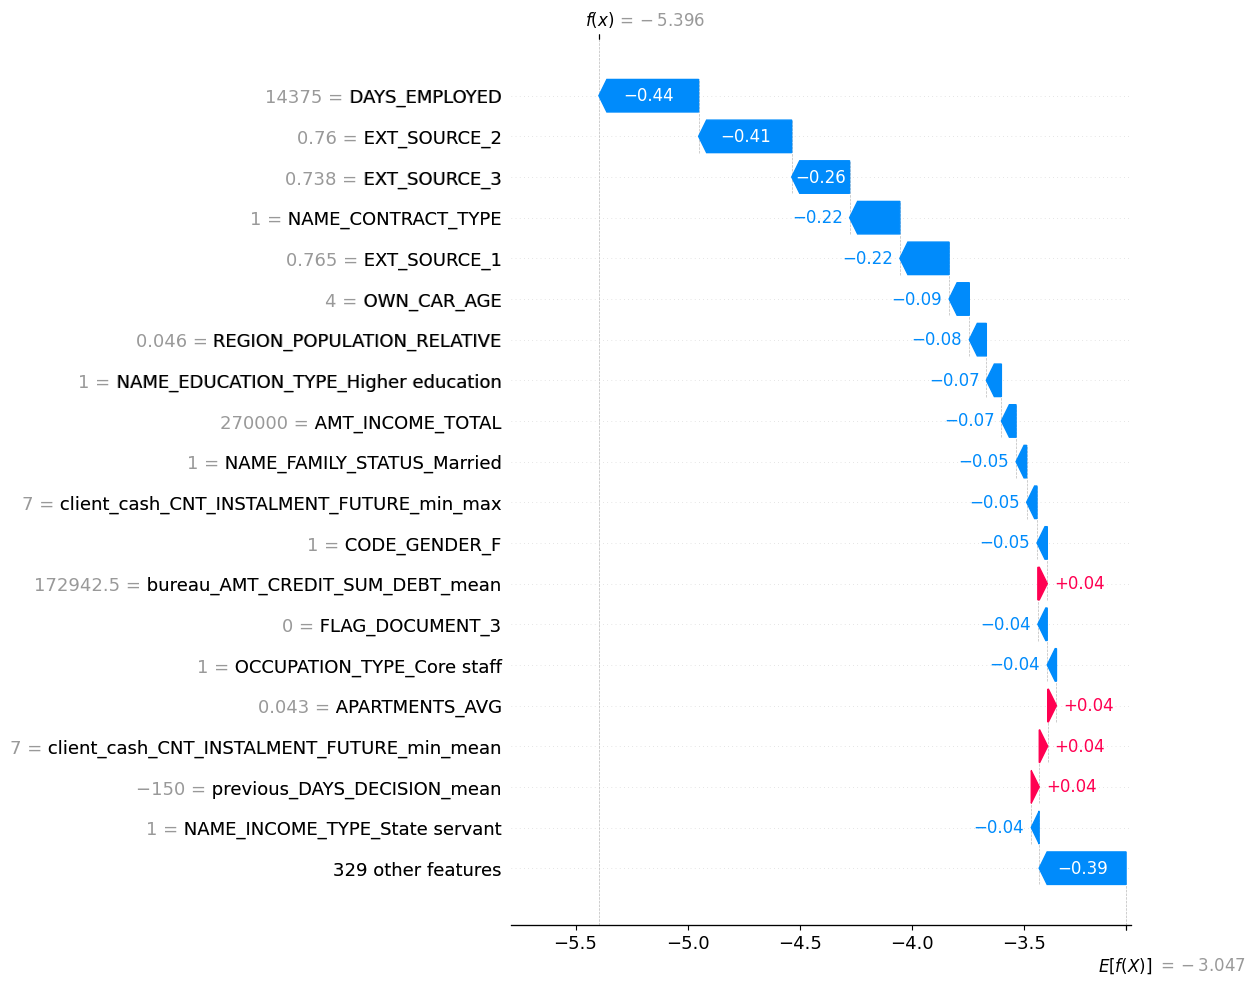

In [55]:
shap.waterfall_plot(shap_values[0], max_display=20)

Ici nous avons l'exemple d'un "très mauvais" client.

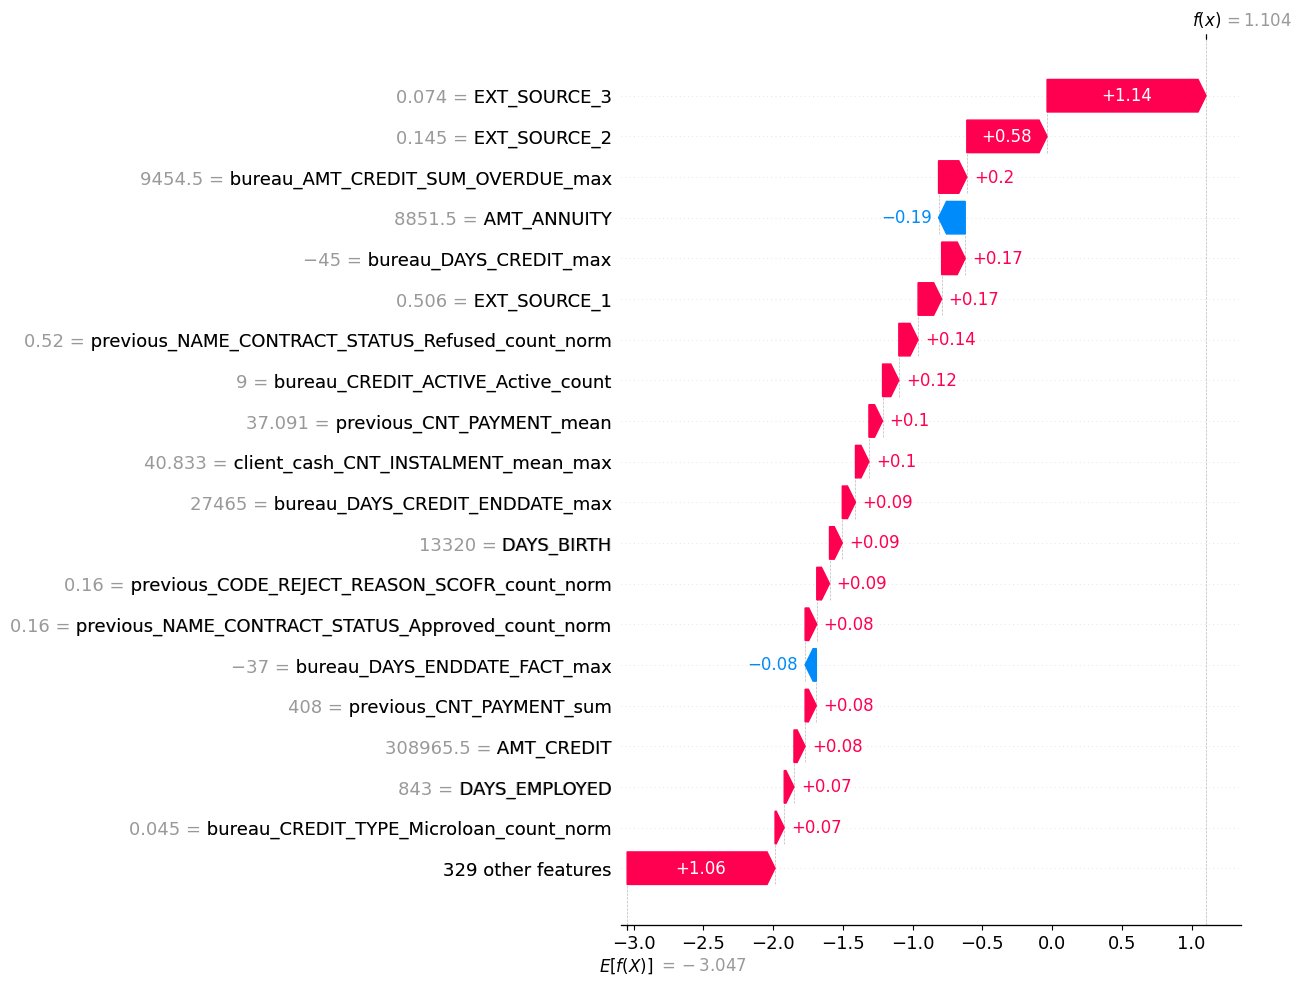

In [56]:
shap.waterfall_plot(shap_values[1], max_display=20)

Ici une explication plus globale des features sur une portion du dataset

In [57]:
shap_values = explainer_train.shap_values(X_train)

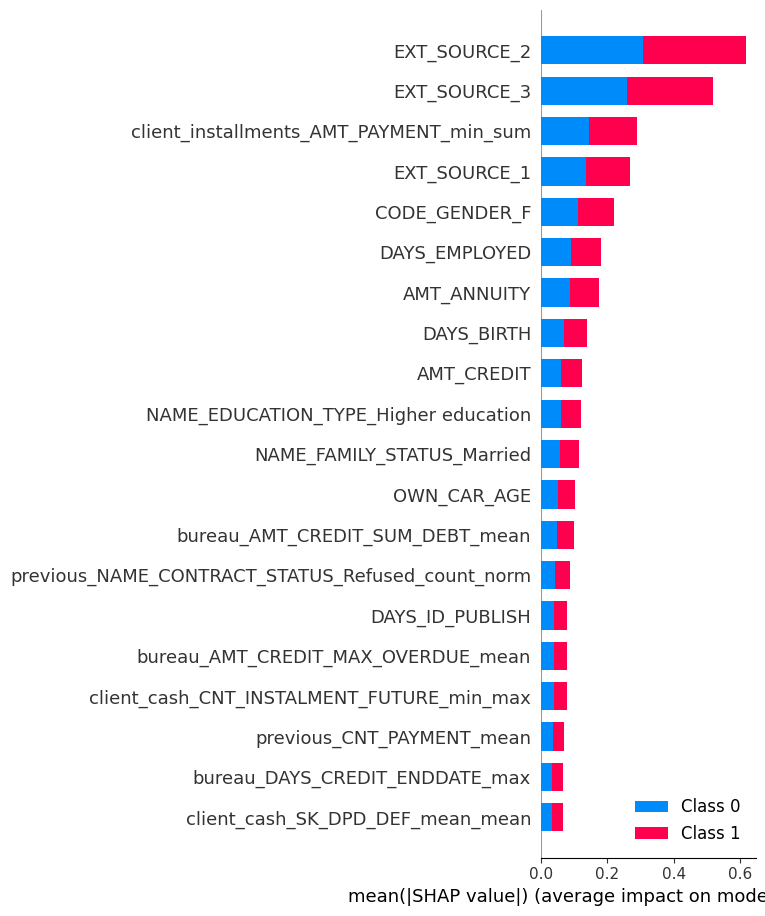

In [58]:
shap_df = working_df.drop(columns = ['TARGET'])
shap.summary_plot(shap_values, shap_df)

# Synthèse et conclusion :

Pour rappel, l'entreprise Home Credit cherche à développer un algorithme de classification pour aider à décider si elle peut, ou non, accorder un pret à un client.  
Nous avons pour cela : 
- Utilisé la totalité des bases de données à notre diposition. 
- Effectué un feature engineering sur chacune d'entres elles, regroupé ces données, et selectionné les plus pertinantes.
- Comparé l'efficasité de différents type de modèles de machine learning sur ces données afin de parvenir à une classification possible, en rapport avec le besoin métier.
- Fine tuné le modèle selectionné pour permetre d'avoir la classification la plus correcte possible, et permettre à Homme Credit d'accoder un prêt un leur client avec le plus de sécurité possible.

Bien qu'une grande partie des features importantes à la classification de ces clients soit difficiles à interpréter (ex : `EXT_SOURCE_1`, `client_installement_AMT_payement_min_sum`) il est néamois possible de les interepréter au niveau global de l'algorithme, mais aussi individuellement par client lors d'une prédiction. Avec une explication des features aux chargés de relation, il leur sera possible de déterminer plus aisément si une étude plus apporfondie du dossier d'un client sera ou non pertinente dans l'eventualité de lui accorder un pret.

____________________________________________________________________
Further reading : 

- Bayesian Optimization
https://www.kaggle.com/code/willkoehrsen/intro-to-model-tuning-grid-and-random-search/notebook#Four-parts-of-Hyperparameter-tuning